In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import rankdata
import statsmodels.api as sm
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
#import wrds
from dateutil.relativedelta import *
from pandas.tseries.offsets import *

In [2]:
#conn = wrds.Connection(wrds_username='******')

### Read Fama French Factor Data

In [3]:
# read Fama-French MoM factor
FFMoM = pd.read_csv('F-F_Momentum_Factor.csv',skiprows=13, nrows=1118)
FFMoM.columns = ['RetDate', 'MoM']
FFMoM['RetDate'] = FFMoM['RetDate'].astype(str)

print('# of missing data: ', sum((FFMoM.MoM == -99.99) | (FFMoM.MoM == -999)))

# of missing data:  0


In [4]:
FFMoM['MoM'] = FFMoM['MoM'] / 100
# calculate Fame-French MoM cumulative dollar value
FFMoM_sub = FFMoM.copy()
FFMoM_sub = FFMoM_sub[FFMoM_sub['RetDate']>='197007']
FFMoM_sub['CumDollarValue'] = (1 + FFMoM_sub['MoM']).cumprod()
FFMoM_sub['drawdown'] = 1 - FFMoM_sub['CumDollarValue'] / FFMoM_sub['CumDollarValue'].cummax()
FFMoM_sub['maxdrawdown'] = FFMoM_sub['drawdown'].expanding().max()

FFMoM_sub.index = np.arange(FFMoM_sub.shape[0])

## Define Functions

In [5]:
# define function to get MDD, drawdown duration, start and end time 
def MDDSummary(MoMRetdf):
    # end of the mdd period
    i = np.argmax(np.array(MoMRetdf['maxdrawdown']))
    # start of mdd period
    j = np.argmax(np.array(MoMRetdf['CumDollarValue'][:i]))
    
    result = (MoMRetdf['RetDate'][j] +'-'+ MoMRetdf['RetDate'][i]).ljust(15).rjust(20)
    result += str(i-j).rjust(10)
    result += str(MoMRetdf['maxdrawdown'][i].round(4)).rjust(12)
    return result

In [6]:
# define function to read MoM results
#    MoM method: T-12 to T-2, T-12 to T-1
#    Rebalance frequency: Annually(Y), Monthly(M)
def ReadMoMResult(FileDir, WeightMethod):
    MoMRets = []
    FileNames = []
    for tf in ['Y', 'M']:
        for mommethod in ['T-12 to T-2', 'T-12 to T-1']:

            filename_cont = '1-year '+WeightMethod+' MoM_'+mommethod+'_'+tf
            FileNames.append(filename_cont)

            df_cont = pd.read_excel(FileDir+filename_cont+'.xlsx')
            df_cont[['RetDate','ConDate','RankDate']] = df_cont[['RetDate','ConDate','RankDate']].astype(str)
            MoMRets.append(df_cont) 
    return MoMRets, FileNames

In [7]:
# define function to draw cumulative returns
def PlotMoMCumRets(MoMRetDF, FFMoMDF, WeightMethod):
    # MoMRetDF: Ind. MoM return dataframe
    # FFMoMFD: Fama French MoM dataframe
    fig, ax = plt.subplots(figsize=(10,5))
    for n in range(4):
        MoMRetDF[n][['RetDate','CumDollarValue']].set_index('RetDate').plot(ax=ax, linewidth=2, logy=True) 
        y_cont = MoMRetDF[n]['CumDollarValue'].round(2).tolist()[-1]
        plt.text(x=600,y=y_cont,s='$'+str(y_cont),fontsize=12)

    FFMoMDF[['RetDate','CumDollarValue']].set_index('RetDate').plot(ax=ax, linewidth=1, logy=True) 
    y_cont = FFMoMDF['CumDollarValue'].round(2).tolist()[-1]
    plt.text(x=600,y=y_cont,s='$'+str(y_cont),fontsize=12)

    plt.title('Cumulative Return of 12-month '+WeightMethod+ ' MoM', fontsize=12)    
    ax.legend(['T-12 to T-2, Y',
               'T-12 to T-1, Y',
               'T-12 to T-2, M',
               'T-12 to T-1, M',
               'Fama-French MoM'], fontsize=12);
    #plt.savefig('Cumulative Return of 12-month EW MoM.eps', format='eps');
    pass

### EW Ind. Momentum

In [8]:
# Notes: modify 'main_dir' if necessary
main_dir = '/Users/guoyangwan/Desktop/Academic/Research/Industry Effect II/EW Results/'
EWMoMRets, EWFileNames = ReadMoMResult(FileDir = main_dir,
                                       WeightMethod = 'EW')

In [9]:
print('Drawdown Period,'.rjust(46), 'Duration(m),', 'Max Drawdown')
for i in range(len(EWMoMRets)):
    print(EWFileNames[i] + MDDSummary(MoMRetdf=EWMoMRets[i]))
print('Fama French MoM'.ljust(27) + MDDSummary(MoMRetdf=FFMoM_sub))

                              Drawdown Period, Duration(m), Max Drawdown
1-year EW MoM_T-12 to T-2_Y     200209-201205         116      0.6794
1-year EW MoM_T-12 to T-1_Y     198011-198405          42      0.6316
1-year EW MoM_T-12 to T-2_M     200806-201101          31      0.6022
1-year EW MoM_T-12 to T-1_M     201601-201712          23      0.5338
Fama French MoM                 200811-200909          10      0.5733


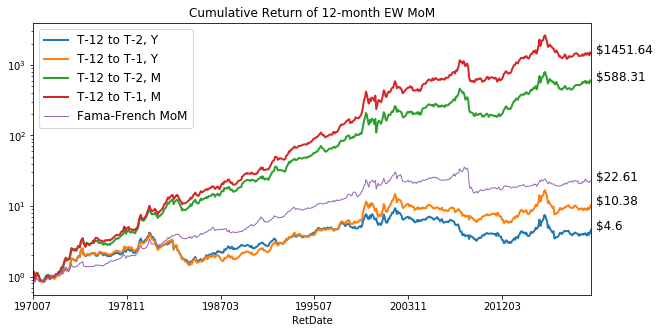

In [10]:
PlotMoMCumRets(MoMRetDF = EWMoMRets, 
               FFMoMDF = FFMoM_sub, 
               WeightMethod = 'EW')

In [11]:
# correlation
print('Fama French MoM'.rjust(45))
for i in range(len(EWMoMRets)):
    print(EWFileNames[i].ljust(30),
    str(np.corrcoef(EWMoMRets[i]['WML'],FFMoM_sub['MoM'])[0][1].round(4)).ljust(10))
    

                              Fama French MoM
1-year EW MoM_T-12 to T-2_Y    0.4277    
1-year EW MoM_T-12 to T-1_Y    0.4517    
1-year EW MoM_T-12 to T-2_M    0.7016    
1-year EW MoM_T-12 to T-1_M    0.719     


## VW Momentum (Weighted by Avg. Cap.)

In [12]:
# Notes: modify 'main_dir' if necessary
main_dir = '/Users/guoyangwan/Desktop/Academic/Research/Industry Effect II/VW (avg cap) Results/'
VW_avgcap_MoMRets, VW_avgcap_FileNames = ReadMoMResult(FileDir = main_dir,
                                                       WeightMethod = 'VW')

In [13]:
print('Drawdown Period,'.rjust(46), 'Duration(m),', 'Max Drawdown')
for i in range(len(VW_avgcap_MoMRets)):
    print(VW_avgcap_FileNames[i] + MDDSummary(MoMRetdf=VW_avgcap_MoMRets[i]))
print('Fama French MoM'.ljust(27) + MDDSummary(MoMRetdf=FFMoM_sub))

                              Drawdown Period, Duration(m), Max Drawdown
1-year VW MoM_T-12 to T-2_Y     200002-201212         154      0.9316
1-year VW MoM_T-12 to T-1_Y     200002-201212         154      0.8626
1-year VW MoM_T-12 to T-2_M     200209-201110         109      0.7575
1-year VW MoM_T-12 to T-1_M     200209-201201         112      0.6533
Fama French MoM                 200811-200909          10      0.5733


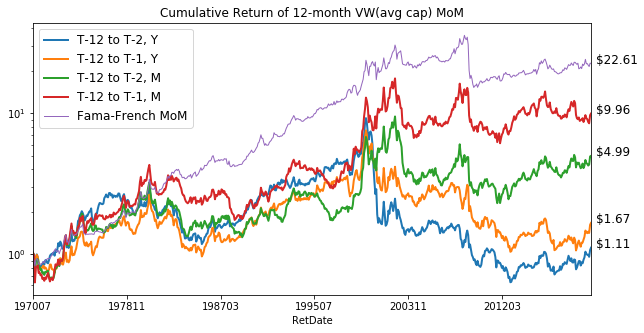

In [14]:
PlotMoMCumRets(MoMRetDF = VW_avgcap_MoMRets, 
               FFMoMDF = FFMoM_sub, 
               WeightMethod = 'VW(avg cap)')

In [15]:
# correlation
print('Fama French MoM'.rjust(45))
for i in range(len(VW_avgcap_MoMRets)):
    print(VW_avgcap_FileNames[i].ljust(30),
    str(np.corrcoef(VW_avgcap_MoMRets[i]['WML'],FFMoM_sub['MoM'])[0][1].round(4)).ljust(10))

                              Fama French MoM
1-year VW MoM_T-12 to T-2_Y    0.4566    
1-year VW MoM_T-12 to T-1_Y    0.5492    
1-year VW MoM_T-12 to T-2_M    0.7437    
1-year VW MoM_T-12 to T-1_M    0.734     


## VW Momentum (Weighted by Total. Cap.)

In [16]:
# Notes: modify 'main_dir' if necessary
main_dir = '/Users/guoyangwan/Desktop/Academic/Research/Industry Effect II/VW (total cap) Results/'
VW_totalcap_MoMRets, VW_totalcap_FileNames = ReadMoMResult(FileDir = main_dir,
                                                           WeightMethod = 'VW')

In [17]:
print('Drawdown Period,'.rjust(46), 'Duration(m),', 'Max Drawdown')
for i in range(len(VW_totalcap_MoMRets)):
    print(VW_totalcap_FileNames[i] + MDDSummary(MoMRetdf=VW_totalcap_MoMRets[i]))
print('Fama French MoM'.ljust(27) + MDDSummary(MoMRetdf=FFMoM_sub))

                              Drawdown Period, Duration(m), Max Drawdown
1-year VW MoM_T-12 to T-2_Y     200002-201811         225      0.9202
1-year VW MoM_T-12 to T-1_Y     200002-201810         224      0.8805
1-year VW MoM_T-12 to T-2_M     200209-201001          88      0.6665
1-year VW MoM_T-12 to T-1_M     200209-201902         197      0.6275
Fama French MoM                 200811-200909          10      0.5733


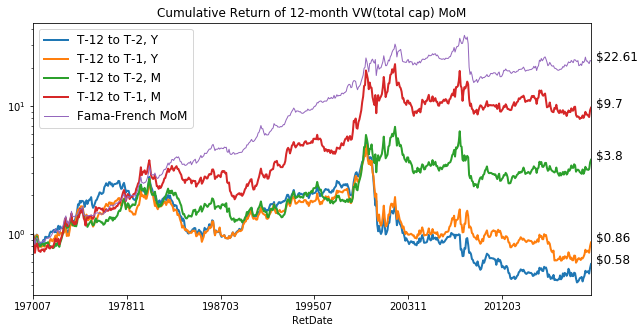

In [18]:
PlotMoMCumRets(MoMRetDF = VW_totalcap_MoMRets, 
               FFMoMDF = FFMoM_sub, 
               WeightMethod = 'VW(total cap)')

In [19]:
# correlation
print('Fama French MoM'.rjust(45))
for i in range(len(VW_totalcap_MoMRets)):
    print(VW_totalcap_FileNames[i].ljust(30),
    str(np.corrcoef(VW_totalcap_MoMRets[i]['WML'],FFMoM_sub['MoM'])[0][1].round(4)).ljust(10))

                              Fama French MoM
1-year VW MoM_T-12 to T-2_Y    0.4707    
1-year VW MoM_T-12 to T-1_Y    0.5307    
1-year VW MoM_T-12 to T-2_M    0.7933    
1-year VW MoM_T-12 to T-1_M    0.7859    


### Size Effect
check whether (EW-VW) is significant

In [20]:
DecileTValue = []
for i in range(len(EWMoMRets)):
    EW_VW_MoMdiff = EWMoMRets[i].iloc[:,3:14] - VW_avgcap_MoMRets[i].iloc[:,3:14]
    
    seriesname = EWFileNames[i][10:]
    decile_t_test = [seriesname]
    for decile in EW_VW_MoMdiff.columns.tolist():
        tvalue = stats.ttest_1samp(EW_VW_MoMdiff.loc[:,decile],0)[0].round(2)
        decile_t_test.append(tvalue)
    
    DecileTValue.append(decile_t_test)

DecileTValue = pd.DataFrame(DecileTValue,
                            columns = ['IndMoM'] + EW_VW_MoMdiff.columns.tolist())

In [21]:
DecileTValue

,IndMoM,decile1,decile2,decile3,decile4,decile5,decile6,decile7,decile8,decile9,decile10,WML
0,MoM_T-12 to T-2_Y,-0.55,-0.35,1.68,0.92,2.19,1.15,1.54,0.91,0.40,0.43,0.82
1,MoM_T-12 to T-1_Y,-0.74,-0.55,1.40,0.44,2.21,0.86,1.00,2.45,0.12,0.72,1.21
2,MoM_T-12 to T-2_M,-1.92,0.88,0.68,0.47,0.32,0.72,1.86,1.31,1.01,2.27,3.50
3,MoM_T-12 to T-1_M,-1.57,1.31,-0.38,0.30,2.31,-0.47,1.46,0.54,1.88,2.74,3.47


### Compare Ind MoM with FF MoM with Regression

#### Compare EW Ind. MoM with FF MoM

In [22]:
for i in range(4):
    print(EWFileNames[i])
    # regression for 1-year IndMoM:  IndMoM = a + b * MoM + e
    X = np.array(FFMoM_sub['MoM'])
    y = np.array(EWMoMRets[i]['WML'])
    
    X1 = sm.add_constant(X)
    model1 = sm.OLS(y, X1).fit()
    
    print('IndMoM = %0.4f + %0.4f * MoM'%(model1.params[0],model1.params[1]))
    print('(%0.2f)'.rjust(16)%model1.tvalues[0], 
          '(%0.2f)'.rjust(9)%model1.tvalues[1])

    # regression for 1-year IndMoM:  MoM = a + b * IndMoM + e

    y1 = sm.add_constant(y)
    model2 = sm.OLS(X, y1).fit()

    print('MoM    = %0.4f + %0.4f * IndMoM'%(model2.params[0],model2.params[1]))
    print('(%0.2f)'.rjust(16)%model2.tvalues[0], 
          '(%0.2f)'.rjust(9)%model2.tvalues[1], '\n\n')

1-year EW MoM_T-12 to T-2_Y
IndMoM = 0.0007 + 0.5424 * MoM
         (0.35)   (11.53)
MoM    = 0.0049 + 0.3372 * IndMoM
         (3.00)   (11.53) 


1-year EW MoM_T-12 to T-1_Y
IndMoM = 0.0019 + 0.5968 * MoM
         (0.89)   (12.34)
MoM    = 0.0043 + 0.3418 * IndMoM
         (2.70)   (12.34) 


1-year EW MoM_T-12 to T-2_M
IndMoM = 0.0065 + 1.0013 * MoM
         (3.53)   (23.99)
MoM    = -0.0000 + 0.4916 * IndMoM
         (-0.01)   (23.99) 


1-year EW MoM_T-12 to T-1_M
IndMoM = 0.0079 + 1.0213 * MoM
         (4.42)   (25.21)
MoM    = -0.0010 + 0.5062 * IndMoM
         (-0.76)   (25.21) 




#### Compare VW Ind. MoM with FF MoM

In [23]:
for i in range(4):
    print(VW_avgcap_FileNames[i])
    # regression for 1-year IndMoM:  IndMoM = a + b * MoM + e
    X = np.array(FFMoM_sub['MoM'])
    y = np.array(VW_avgcap_MoMRets[i]['WML'])
    
    X1 = sm.add_constant(X)
    model1 = sm.OLS(y, X1).fit()
    
    print('IndMoM = %0.4f + %0.4f * MoM'%(model1.params[0],model1.params[1]))
    print('(%0.2f)'.rjust(16)%model1.tvalues[0], 
          '(%0.2f)'.rjust(9)%model1.tvalues[1])

    # regression for 1-year IndMoM:  MoM = a + b * IndMoM + e

    y1 = sm.add_constant(y)
    model2 = sm.OLS(X, y1).fit()

    print('MoM    = %0.4f + %0.4f * IndMoM'%(model2.params[0],model2.params[1]))
    print('(%0.2f)'.rjust(16)%model2.tvalues[0], 
          '(%0.2f)'.rjust(9)%model2.tvalues[1], '\n\n')

1-year VW MoM_T-12 to T-2_Y
IndMoM = -0.0019 + 0.6713 * MoM
         (-0.81)   (12.51)
MoM    = 0.0055 + 0.3106 * IndMoM
         (3.48)   (12.51) 


1-year VW MoM_T-12 to T-1_Y
IndMoM = -0.0021 + 0.8144 * MoM
         (-0.94)   (16.01)
MoM    = 0.0051 + 0.3703 * IndMoM
         (3.44)   (16.01) 


1-year VW MoM_T-12 to T-2_M
IndMoM = -0.0023 + 1.1898 * MoM
         (-1.19)   (27.11)
MoM    = 0.0038 + 0.4648 * IndMoM
         (3.22)   (27.11) 


1-year VW MoM_T-12 to T-1_M
IndMoM = -0.0011 + 1.2088 * MoM
         (-0.53)   (26.34)
MoM    = 0.0034 + 0.4457 * IndMoM
         (2.76)   (26.34) 




**Save file with top/bottom deciles industry from Jan 2000 to 2020<br>
Each row contains 10 industries for each month**

In [51]:
main_dir = '/Users/guoyangwan/Desktop/Academic/Research/Industry Effect II/EW Results/'
file_name = '/1-year EW MoM_T-12 to T-1_M.xlsx'

EWDecileInd = pd.read_excel(main_dir+file_name, sheet_name='decile ind')

In [52]:
EWDecileInd[['RetDate','ConDate','RankDate']] = EWDecileInd[['RetDate','ConDate','RankDate']].astype(str)
#EWDecileInd = EWDecileInd[EWDecileInd.RetDate >=200001][['RetDate','decile1','decile10']]

In [53]:
import ast
EWDecileInd['decile1'] = [ast.literal_eval(ind) for ind in EWDecileInd.decile1.tolist()]
EWDecileInd['decile10'] = [ast.literal_eval(ind) for ind in EWDecileInd.decile10.tolist()]

In [54]:
ListofColumnNames_decile1 = list(map(( lambda x: 'decile1_' + x), list(map(str, range(1, 6))) ))
ListofColumnNames_decile10 = list(map(( lambda x: 'decile10_' + x), list(map(str, range(1, 6))) ))

EWDecileInd[ListofColumnNames_decile1] = pd.DataFrame(EWDecileInd.decile1.tolist(), index= EWDecileInd.index)
EWDecileInd[ListofColumnNames_decile10] = pd.DataFrame(EWDecileInd.decile10.tolist(), index= EWDecileInd.index)

In [56]:
EWDecileInd.head(n=3)

,RetDate,ConDate,RankDate,decile1,decile2,decile3,decile4,decile5,decile6,decile7,...,decile1_1,decile1_2,decile1_3,decile1_4,decile1_5,decile10_1,decile10_2,decile10_3,decile10_4,decile10_5
0,197007,197006,197006,"[Softw, Other, Agric, Hlth, PerSv]","['Aero', 'Toys', 'RlEst', 'Chips', 'Meals']","['Cnstr', 'Hardw', 'Whlsl', 'Clths', 'Books']","['Trans', 'Fun', 'Boxes', 'Oil', 'ElcEq']","['Guns', 'Rubbr', 'BusSv', 'Hshld']","['Fin', 'Autos', 'LabEq', 'Txtls', 'BldMt']","['Rtail', 'Steel', 'Mach', 'Paper', 'Ships']",...,Softw,Other,Agric,Hlth,PerSv,Util,Beer,Drugs,Coal,Smoke
1,197008,197007,197007,"[Softw, Other, Hlth, Agric, Aero]","['Toys', 'Hardw', 'PerSv', 'Chips', 'Meals']","['Cnstr', 'RlEst', 'Whlsl', 'Fun', 'Boxes']","['LabEq', 'Clths', 'Trans', 'Books', 'Rubbr']","['Hshld', 'BusSv', 'ElcEq', 'Fin']","['Guns', 'Oil', 'BldMt', 'Txtls', 'Autos']","['MedEq', 'Mach', 'Steel', 'Chems', 'Rtail']",...,Softw,Other,Hlth,Agric,Aero,Beer,Gold,Drugs,Coal,Smoke
2,197009,197008,197008,"[Softw, Other, Hlth, Agric, Aero]","['Toys', 'PerSv', 'Hardw', 'Meals', 'RlEst']","['Chips', 'Fun', 'Cnstr', 'Whlsl', 'Boxes']","['Books', 'MedEq', 'Hshld', 'Trans', 'Rubbr']","['LabEq', 'BusSv', 'Fin', 'Clths']","['ElcEq', 'BldMt', 'Oil', 'Txtls', 'Rtail']","['Autos', 'Mach', 'Steel', 'Chems', 'Guns']",...,Softw,Other,Hlth,Agric,Aero,Drugs,Gold,Util,Smoke,Coal


**Compute the average cap for top and button decile**

In [73]:
RawData = pd.read_csv('49_Industry_Portfolios.csv')

In [74]:
# get number of firms per ind. portfolio
NumFirmPerInd = RawData.iloc[2460:3585,:]
NumFirmPerInd.columns = ['date'] + list(map(str.strip, NumFirmPerInd.iloc[0,:].dropna().tolist()))
NumFirmPerInd = NumFirmPerInd.drop(labels=[2460])
NumFirmPerInd.date = NumFirmPerInd.date.astype(str)


NumFirmPerInd = NumFirmPerInd[NumFirmPerInd.date >= '197007'].set_index('date')
NumFirmPerInd = NumFirmPerInd.astype(int)

In [75]:
# check NULL
np.where(((NumFirmPerInd==-99.99) | 
          (NumFirmPerInd==-999) ) )

(array([], dtype=int64), array([], dtype=int64))

In [76]:
NumFirmPerInd.head(n=3)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
197007,6,70,13,16,10,44,22,28,96,73,...,36,78,59,166,32,48,19,23,56,5
197008,6,70,13,16,10,44,22,28,96,73,...,36,78,59,165,31,48,19,22,56,5
197009,6,70,13,16,10,44,22,28,96,73,...,36,78,59,165,31,48,19,22,55,5


In [77]:
AvgIndCap = RawData.iloc[3588:4713,:]
AvgIndCap.columns = ['date'] + list(map(str.strip, AvgIndCap.iloc[0,:].dropna().tolist()))
AvgIndCap = AvgIndCap.drop(labels=[3588])
AvgIndCap.date = AvgIndCap.date.astype(str)

AvgIndCap = AvgIndCap[AvgIndCap.date >= '197007'].set_index('date')
AvgIndCap = AvgIndCap.astype(float)

In [78]:
# check NULL
np.where(((AvgIndCap == -99.99) | 
          (AvgIndCap == -999) ) )

(array([], dtype=int64), array([], dtype=int64))

In [79]:
AvgIndCap.head(n=3)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
197007,49.61,211.34,451.77,179.09,399.37,70.49,73.36,95.75,420.45,41.92,...,239.92,102.00,33.50,153.70,82.18,210.88,302.34,39.47,147.14,12.93
197008,48.95,222.63,478.14,191.00,412.85,79.11,74.20,108.21,439.31,45.26,...,254.21,110.43,34.98,171.29,85.50,224.46,332.77,44.57,161.68,12.82
197009,48.80,222.78,469.36,185.26,411.47,87.76,76.61,114.90,456.78,48.42,...,273.82,118.86,37.20,179.33,91.04,238.47,336.68,47.31,173.14,14.69


In [80]:
TotalIndCap = AvgIndCap * NumFirmPerInd

TotalIndCap = TotalIndCap.reset_index()
AvgIndCap = AvgIndCap.reset_index()
NumFirmPerInd = NumFirmPerInd.reset_index()

In [101]:
AvgTopBtmCap = []
for date in TotalIndCap.date.tolist():
    total_decile1_cap = TotalIndCap[TotalIndCap.date==date]\
                                   [EWDecileInd[EWDecileInd.RetDate==date]['decile1'].tolist()[0]]\
                                   .sum(axis=1).tolist()[0]
    total_decile1_firms = NumFirmPerInd[NumFirmPerInd.date==date]\
                                       [EWDecileInd[EWDecileInd.RetDate==date]['decile1'].tolist()[0]]\
                                       .sum(axis=1).tolist()[0]
    
    total_decile10_cap = TotalIndCap[TotalIndCap.date==date]\
                                    [EWDecileInd[EWDecileInd.RetDate==date]['decile10'].tolist()[0]]\
                                    .sum(axis=1).tolist()[0]
    total_decile10_firms = NumFirmPerInd[NumFirmPerInd.date==date]\
                                        [EWDecileInd[EWDecileInd.RetDate==date]['decile10'].tolist()[0]]\
                                        .sum(axis=1).tolist()[0]
    
    avg_decile1_cap = total_decile1_cap / total_decile1_firms
    avg_decile10_cap = total_decile10_cap / total_decile10_firms
    
    AvgTopBtmCap.append([date,avg_decile1_cap, avg_decile10_cap])

In [102]:
AvgTopBtmCap = pd.DataFrame(AvgTopBtmCap, columns=['RetDate','Btm Avg Cap', 'Top Avg Cap'])
AvgTopBtmCap[['Btm Avg Cap', 'Top Avg Cap']] = AvgTopBtmCap[['Btm Avg Cap', 'Top Avg Cap']].round(2)

In [103]:
# EWDecileInd[['RetDate']+ListofColumnNames_decile1+ListofColumnNames_decile10]\
#            .merge(AvgTopBtmCap, how='left', on='RetDate')\
#            .to_excel(main_dir+'Top Btm Ind 200001-202002.xlsx', index=False, header=True)

### Test Size Effect

In [104]:
AvgTopBtmCap['TopBtmAvgCapDiff'] = AvgTopBtmCap['Top Avg Cap'] - AvgTopBtmCap['Btm Avg Cap']
AvgTopBtmCap['Decade'] = AvgTopBtmCap['RetDate'].str[:4].astype(int) // 10 * 10

In [126]:
print('Decade', 't-value')
for decade in AvgTopBtmCap.Decade.unique().tolist()[:-1]:
    tvalue = stats.ttest_1samp(AvgTopBtmCap[AvgTopBtmCap.Decade == decade]['TopBtmAvgCapDiff'],0)[0].round(2)
    print(str(decade).ljust(6), tvalue)

tvalue = stats.ttest_1samp(AvgTopBtmCap['TopBtmAvgCapDiff'],0)[0].round(2)
print('\nTotal period t-value: ', tvalue)

Decade t-value
1970   5.56
1980   7.53
1990   4.21
2000   9.03
2010   3.21

Total period t-value:  8.41


In [127]:
# test size effect from Fama French MoM-Size decile portfolio

#### Graph the two mom ( stock vs ind)

In [41]:
main_dir = '/Users/guoyangwan/Desktop/Academic/Research/Industry Effect II/EW Results/'
file_name = '1-year EW MoM_T-12 to T-1_M'

EWDecileRet = pd.read_excel(main_dir+file_name+'.xlsx', sheet_name='decile ret')
EWDecileRet[['RetDate','ConDate','RankDate']] = EWDecileRet[['RetDate','ConDate','RankDate']].astype(str)

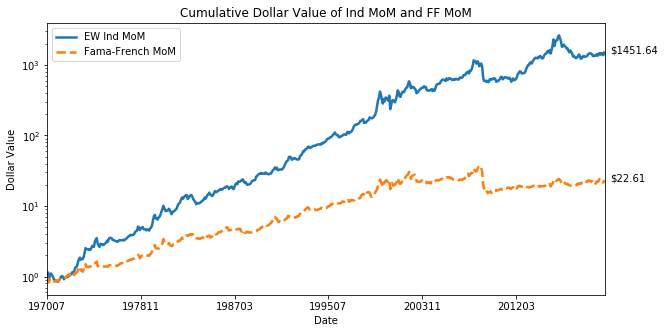

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
EWDecileRet[['RetDate','CumDollarValue']].set_index('RetDate').plot(ax=ax, linewidth=2.5, logy=True) 
y_cont = EWDecileRet['CumDollarValue'].round(2).tolist()[-1]
plt.text(x=600,y=y_cont,s='$'+str(y_cont))

FFMoM_sub[['RetDate','CumDollarValue']].set_index('RetDate').plot(ax=ax, linewidth=2.5, logy=True, linestyle='--') 
y_cont = FFMoM_sub['CumDollarValue'].round(2).tolist()[-1]
plt.text(x=600,y=y_cont,s='$'+str(y_cont))


plt.xlabel('Date')
plt.ylabel('Dollar Value')
plt.title('Cumulative Dollar Value of Ind MoM and FF MoM')    
ax.legend(['EW Ind MoM',
           'Fama-French MoM'])



ax.set_rasterized(True)
# plt.savefig('Cumulative Return of Ind MoM and FF MoM (1970-2020).eps', format='eps');
# plt.savefig('Cumulative Return of Ind MoM and FF MoM (1970-2020).png', format='png');

In [242]:
# EWDecileRet[['RetDate','WML','CumDollarValue','drawdown','maxdrawdown']] \
#            .merge(FFMoM_sub, how='left', on='RetDate', suffixes=('_ind', '_ff')) \
#            .set_index('RetDate').round(4) \
#            .to_excel(main_dir+'Ind MoM Ret(MDD) vs FF MoM.xlsx', index=True, header=True)